In [1]:
import vice

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import surp

import surp.gce_math as gcem
import arya

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from mc_plot_utils import MCMCResult

In [97]:
import mc_plot_utils

In [6]:
df = pd.read_csv("yield_fits.tsv", sep=r"\s+", comment="#")
df

,model,y0,zeta0,zeta0_err,zeta1,zeta1_err
0,fruity,3.110,3.7,0.3,-3.5,0.3
1,aton,-0.009,1.0,1.9,-10.0,3.0
2,monash,2.960,2.3,0.5,-11.0,1.0
3,nugrid,9.250,8.1,1.9,-4.6,1.7
4,fruity_mf0.5,2.830,3.3,0.2,-1.8,0.2
5,fruity_mf0.7,3.600,4.2,0.3,-3.1,0.3
6,fruity_mf1.5,3.110,3.4,0.2,-3.0,0.2


In [7]:
yagb_props = {}

for _, row in df.iterrows():
    yagb_props[row.model] = {
        "y0": row.y0 * 1e-4,
        "y_a": row.zeta0 * 1e-4,
        "zeta_a": row.zeta1 * 1e-4,
    }

yagb_props["analytic"] = {
    "y0": 1e-3,
    "y_a": 1e-3,
    "zeta_a": 1e-3
}

yagb_props

{'fruity': {'y0': 0.000311, 'y_a': 0.00037000000000000005, 'zeta_a': -0.00035},
 'aton': {'y0': -9e-07, 'y_a': 0.0001, 'zeta_a': -0.001},
 'monash': {'y0': 0.000296, 'y_a': 0.00022999999999999998, 'zeta_a': -0.0011},
 'nugrid': {'y0': 0.000925, 'y_a': 0.00081, 'zeta_a': -0.00045999999999999996},
 'fruity_mf0.5': {'y0': 0.000283, 'y_a': 0.00033, 'zeta_a': -0.00018},
 'fruity_mf0.7': {'y0': 0.00036, 'y_a': 0.00042, 'zeta_a': -0.00031},
 'fruity_mf1.5': {'y0': 0.000311,
  'y_a': 0.00034,
  'zeta_a': -0.00030000000000000003},
 'analytic': {'y0': 0.001, 'y_a': 0.001, 'zeta_a': 0.001}}

In [13]:
def load_model(filename, props, test=False, burn=0):
    y0 = props["y0"],
    y_a = props["y_a"]
    zeta_a = props["zeta_a"]
    
    if test:
        result = MCMCResult.from_test_file(filename, burn=burn)
    else:
        result = MCMCResult.from_file(filename, y0=y0, burn=burn, y_a=y_a, zeta_a=zeta_a)
    return result

# Body

## Main comparisons

In [14]:
results = {}

In [15]:
results["fiducial"] = load_model("fiducial", yagb_props["fruity"])

length of samples =  48000


In [16]:
results["analytic"] = load_model("analytic_quad", yagb_props["analytic"])

length of samples =  48000


In [18]:
results["analytic_all"] = load_model("analytic_all", yagb_props["analytic"])

length of samples =  48000


In [19]:
res_bad = load_model("fiducial_caah_only", yagb_props["fruity"])

length of samples =  160000


In [61]:
results["eta2"] = load_model("eta2", yagb_props["fruity"])

length of samples =  48000


In [21]:
results["lateburst"] = load_model("lateburst", yagb_props["fruity"])

length of samples =  48000


In [22]:
results["twoinfall"] = load_model("twoinfall", yagb_props["fruity"])

length of samples =  48000


In [23]:
results["snia_1.2"] = load_model("snia_1.2", yagb_props["fruity"])

length of samples =  48000


In [24]:
results["old_migration"] = load_model("fiducial_old_migration", yagb_props["fruity"])

length of samples =  48000


In [26]:
oob_results = {}

In [27]:
oob_results["mf0.5"] = load_model("fruity_mf0.5", yagb_props["fruity_mf0.5"])

adding  alpha
length of samples =  48000


In [28]:
oob_results["mf0.7"] = load_model("fruity_mf0.7", yagb_props["fruity_mf0.7"])

adding  alpha
length of samples =  48000


In [29]:
oob_results["mf1.5"] = load_model("fruity_mf1.5", yagb_props["fruity_mf1.5"])

adding  alpha
length of samples =  48000


## Agb models

In [30]:
results["fruity"] = load_model("fruity_quad", yagb_props["fruity"])

length of samples =  48000


In [31]:
results["fruity_m0.7"] = load_model("fruity_mf0.7_alpha", yagb_props["fruity_mf0.7"])

length of samples =  48000


In [32]:
results["fruity_lin"] = load_model("fruity_lin", yagb_props["fruity"])

adding  alpha
length of samples =  48000


In [33]:
results["aton"] = load_model("aton_quad", yagb_props["aton"])

length of samples =  48000


In [34]:
results["monash"] = load_model("monash_quad", yagb_props["monash"])

length of samples =  48000


In [35]:
results["nugrid"] = load_model("nugrid_quad", yagb_props["nugrid"])

length of samples =  48000


## Other analytic

In [36]:
results["analytic_eta2"] = load_model("analytic_eta2", yagb_props["analytic"])

length of samples =  48000


In [37]:
results["analytic_lateburst"] = load_model("analytic_lateburst", yagb_props["analytic"])

length of samples =  48000


In [38]:
results["analytic_twoinfall"] = load_model("analytic_twoinfall_liam", yagb_props["analytic"])

length of samples =  48000


In [39]:
res_bad_analytic = load_model("analytic_caah_only", yagb_props["analytic"])

length of samples =  160000


## OOb AGBS

In [ ]:
oob_results = {}

In [ ]:
oob_results["fruity"] = plot_all("fruity_oob", y0=3.229e-4, y_a=3.82e-4, zeta_a=-3.5e-4)

In [ ]:
oob_results["aton"] = plot_all("aton_oob",  y0=0.285e-4, y_a=1.85e-4, zeta_a=-9.4e-5)

In [ ]:
oob_results["monash"] = plot_all("monash_oob", y0=3.444e-4, y_a=2.8e-4, zeta_a=-10.1e-4)

In [ ]:
oob_results["nugrid"] = plot_all("nugrid_oob",  y0=10.95e-4, y_a=5.9e-4, zeta_a=-5.7e-4)

### mass shifts

## Extra

In [ ]:
results["analytic_lin"] = plot_all("analytic_lin", y0=1e-3, y_a=1e-3, zeta_a=-1e-3)

In [ ]:
plot_all("analytic_quad_m0.2", y0=1e-3, y_a=1e-3, zeta_a=-1e-3)

In [ ]:
results["fruity_mh0.2"] = plot_all("fruity_mh0.2", y0=3.229e-4, y_a=3.8e-4, zeta_a=-3.5e-4)

In [ ]:
y = surp.yield_models.Quadratic_CC(y0=0.25e-3, zeta=1e-3, A=1e-3, Z1=0.016*10**-0.5)

In [ ]:
y(0.016 * 10**-0.0)

In [ ]:
results["fruity_mh0.5"] = plot_all("fruity_mh0.5", y0=3.229e-4, y_a=3.8e-4, zeta_a=-3.5e-4)

In [32]:
res = results["fruity"]

KeyError: 'fruity'

In [ ]:
res.samples[
    (np.percentile(res.samples.alpha, 99.95) > res.samples.alpha) 
    & (res.samples.alpha > np.percentile(res.samples.alpha, 99.85))].median()

In [ ]:
res.samples[
    (np.percentile(res.samples.alpha, 100 - 99.85) > res.samples.alpha) 
    & (res.samples.alpha > np.percentile(res.samples.alpha, 100 - 99.95))].median()

In [ ]:
ana = results["analytic"]

plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.50, "A_cc": 2.65}, ana.ah, ana.labels, label="mean")
plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.36, "A_cc": 2.65}, ana.ah, ana.labels, label="low z1", linestyle="--")
plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.50, "A_cc": 2.25}, ana.ah, ana.labels, label="low z2", linestyle="--")
plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.36, "A_cc": 2.25}, ana.ah, ana.labels, label="low z1 z2")
plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.60, "A_cc": 3.0}, ana.ah, ana.labels, label="high z1 z2")
plot_obs_caah(ana, color="black")
arya.Legend(-1, color_only=True)

plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

In [ ]:
ana = results["analytic"]

plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.50, "A_cc": 2.65}, ana.afe, ana.labels, label="mean")
plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.36, "A_cc": 2.25}, ana.afe, ana.labels, label="low z1 z2")
plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.60, "A_cc": 3.0}, ana.afe, ana.labels, label="high z1 z2")
plot_obs_caafe(ana, color="black")
arya.Legend(-1, color_only=True)

plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

## Surveys

In [ ]:
results["v21"] = plot_all("fiducial_vincenzo21", y0=1e-3, y_a=1e-3, zeta_a=-1e-3)

In [ ]:
results["gso"] = plot_all("fiducial_gso", y0=1e-3, y_a=1e-3, zeta_a=-1e-3)

In [ ]:
results["galah"] = plot_all("fiducial_galah", y0=1e-3, y_a=1e-3, zeta_a=-1e-3)

## Test Cases

In [ ]:
test_results = {}

In [ ]:
test_results["NUTS"] = plot_all("NUTS", test=True)

In [ ]:
test_results["HMC"] = plot_all("HMC", test=True)

In [ ]:
test_results["RWMH"] = plot_all("RWMH", test=True)

In [ ]:
test_results["both_sigma"] = plot_all("both_sigma", test=True)

In [ ]:
test_results["fine_bins"] = plot_all("fine_bins", test=True)

In [ ]:
test_results["superfine_bins"] = plot_all("superfine_bins", test=True)

In [ ]:
test_results["both_sigma"] = plot_all("both_sigma", test=True)

In [ ]:
test_results["equal_num_bins"] = plot_all("equal_num_bins", test=True)

In [ ]:
test_results["add_rand_scatter"] = plot_all("add_rand_scatter", test=True)

In [ ]:
test_results["equalnum_fine"] = plot_all("equalnum_fine", test=True)

In [ ]:
test_results["equal_num_bins"] = plot_all("equal_num_bins", test=True)

In [ ]:
test_results["t_test"] = plot_all("t_test", test=True)

In [ ]:
test_results["kstest_samples"] = plot_all("ks_test", test=True)

In [ ]:
test_results["2s"] = plot_all("both_sigma", test=True)

# Comparisons

## Main comparions

![](plots/figures/mcmc_corner.png)

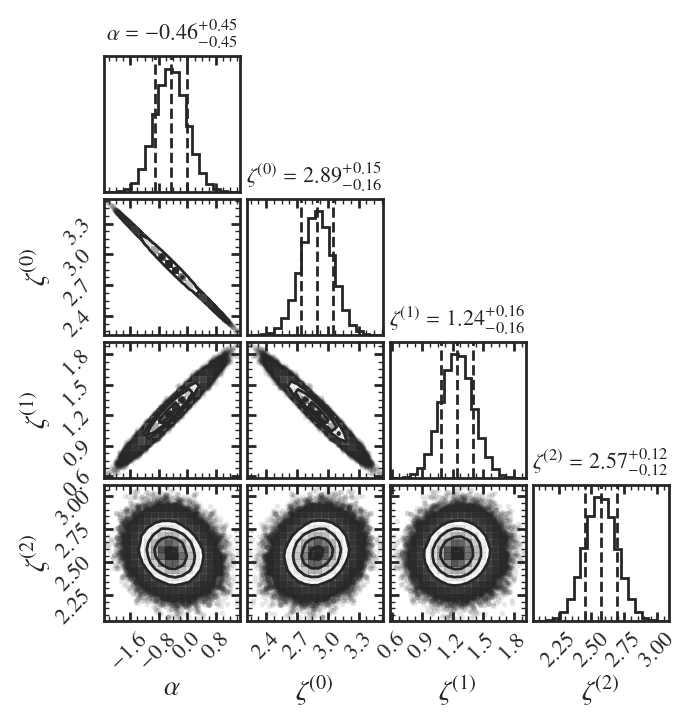

In [174]:
fig = plt.figure(figsize=(3.3, 3.3))

plot_corner(res_bad, 
            fig = fig,
            labels={
    "alpha": r"$\alpha$",
    "y0_cc": r"$\zeta^{(0)}$",
    "zeta_cc": r"$\zeta^{(1)}$",
    "A_cc": r"$\zeta^{(2)}$",},
            labelpad=0.1,
           )

plt.savefig("figures/mcmc_corner_bad.pdf")

In [41]:
agb_interpolator = surp.agb_interpolator.interpolator

In [42]:
y_z0 = lambda z: 1e-3
y_z1 = np.vectorize(lambda z: -1*y_z0(z) + surp.yield_models.BiLogLin_CC(y0=0.001, zeta=0.001, y1=0)(z))
y_z2 = np.vectorize(surp.yield_models.Quadratic_CC(y0=0, zeta=0, A=0.001, Z1=surp.Z_SUN * 0.1))

Y_agbs = {
    "fruity": agb_interpolator("c"),
    "fruity_m0.7": agb_interpolator("c", mass_factor=0.7),
    "aton": agb_interpolator("c", study="ventura13"),
    "monash": agb_interpolator("c", study="karakas16"),
    "nugrid": agb_interpolator("c", study="pignatari16"),
    "analytic": surp.yield_models.C_AGB_Model(y0=1e-3, zeta=1e-3, tau_agb=1, t_D=0.15)
}

In [43]:
results["fruity"].samples

,iteration,chain,y0_cc,A_cc,alpha,zeta_cc,sigma_int,lp,n_steps,is_accept,...,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size,f_agb,y_tot,f_agb_a,y_tot_a,zeta1_a
0,1001,1,1.896945,2.679528,2.273340,2.140649,0.111125,14.312537,3.0,1.0,...,0.237846,2.0,0.0,0.109514,0.109514,0.271514,0.002604,0.307199,0.002738,0.001345
1,1002,1,2.030801,2.011681,2.158230,2.129537,0.104287,13.499038,47.0,1.0,...,-0.544645,5.0,0.0,0.109514,0.109514,0.248411,0.002702,0.282237,0.002829,0.001374
2,1003,1,2.042852,2.065576,2.154263,2.111149,0.103524,13.123218,7.0,1.0,...,0.661475,3.0,0.0,0.109514,0.109514,0.246966,0.002713,0.280668,0.002840,0.001357
3,1004,1,2.048364,2.544283,2.017665,2.163870,0.073470,16.096093,31.0,1.0,...,-0.627604,5.0,0.0,0.109514,0.109514,0.234502,0.002676,0.267107,0.002795,0.001458
4,1005,1,1.805345,2.695379,2.670370,2.355013,0.094622,16.982861,63.0,1.0,...,-0.343486,5.0,0.0,0.109514,0.109514,0.315075,0.002636,0.353706,0.002793,0.001420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,3996,16,1.986672,3.230904,2.008677,2.293643,0.100666,12.859536,31.0,1.0,...,-0.178830,5.0,0.0,0.107778,0.107778,0.239222,0.002611,0.272250,0.002730,0.001591
47996,3997,16,1.990656,3.228914,2.032949,2.291061,0.101552,13.446944,3.0,1.0,...,-0.132804,2.0,0.0,0.107778,0.107778,0.241049,0.002623,0.274237,0.002743,0.001580
47997,3998,16,1.980505,3.048349,2.173220,2.458882,0.090336,15.576767,15.0,1.0,...,0.086925,4.0,0.0,0.107778,0.107778,0.254434,0.002656,0.288764,0.002785,0.001698
47998,3999,16,1.782444,2.234949,2.797377,2.273312,0.081772,15.617698,63.0,1.0,...,0.326315,5.0,0.0,0.107778,0.107778,0.327995,0.002652,0.367361,0.002817,0.001294


In [44]:
M_H=np.linspace(-0.5, 0.5, 1000)
Z = gcem.MH_to_Z(M_H)
surp.set_yields(verbose=False)
ys_fiducial = surp.yields.calc_y(Z)

Z = gcem.MH_to_Z(M_H)
y_agbs = {}
for key, Y_agb in Y_agbs.items():
    print(Y_agb)
    vice.yields.agb.settings["c"] = Y_agb
    ys_a = surp.yields.calc_y(Z, kind="agb")
    
    y_agbs[key] = ys_a


1.00 × cristallo11
1.00 × cristallo11
1.00 × ventura13
1.00 × karakas16
1.00 × pignatari16
(1.00e-03 + 1.00e-03(Z-Zo)), t_D=0.15, tau=1.00


In [45]:
def plot_y_tot_mean(result, ys_a, M_H=M_H, **kwargs):
    samples = result.samples
    Z = gcem.MH_to_Z(M_H)
        
    ys_z0 = y_z0(Z)
    ys_z1 = y_z1(Z)
    ys_z2 = y_z2(Z)
    ymg = vice.yields.ccsne.settings["mg"]

    sample = samples.median()
    yt = sample.y0_cc * ys_z0 + sample.zeta_cc * ys_z1 + sample.A_cc * ys_z2 + sample.alpha * ys_a
    plt.plot(M_H, yt / ymg, **kwargs)


In [46]:
results["analytic"].samples.median()

iteration                       2500.500000
chain                              8.500000
y0_cc                              2.222845
A_cc                               2.479598
alpha                              0.535534
zeta_cc                            1.432152
sigma_int                          0.048572
lp                                31.712472
n_steps                           31.000000
is_accept                          1.000000
acceptance_rate                    0.939118
log_density                       31.712472
hamiltonian_energy               -29.211793
hamiltonian_energy_error           0.000000
max_hamiltonian_energy_error       0.115235
tree_depth                         4.000000
numerical_error                    0.000000
step_size                          0.154648
nom_step_size                      0.154648
f_agb                              0.194152
y_tot                              0.002758
f_agb_a                            0.194152
y_tot_a                         

In [47]:
def plot_y_tot(result, ys_a, thin=10, M_H=M_H, color="black", alpha=None):
    samples = result.samples
    Z = gcem.MH_to_Z(M_H)
    if alpha is None:
        alpha = 1 / len(samples)**(1/3) / 10
        
    ys_z0 = y_z0(Z)
    ys_z1 = y_z1(Z)
    ys_z2 = y_z2(Z)
    ymg = vice.yields.ccsne.settings["mg"]

    for i, sample in samples[::thin].iterrows():
        yt = sample.y0_cc * ys_z0 + sample.zeta_cc * ys_z1 + sample.A_cc * ys_z2 + sample.alpha * ys_a
        plt.plot(M_H, yt / ymg, color=color, alpha=alpha, rasterized=True)
    





In [137]:
plot_labels = {
    "fruity": r"FRUITY",
    "aton": r"ATON",
    "monash": r"Monash",
    "nugrid": r"NuGrid",
   # "analytic": r"analytic",
    "fruity_m0.7": r"FRUITY m0.7",

    # "eta2": r"$y\rightarrow 2y$",
    # "lateburst": r"lateburst",
    # "twoinfall": r"twoinfall",
}

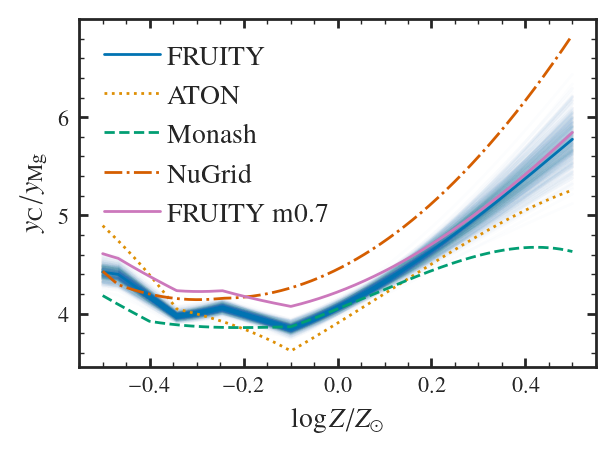

In [139]:

plt.figure()
plot_y_tot(results["fruity"], y_agbs["fruity"], thin=100, alpha=0.01, color=arya.COLORS[0])

for i, (key, label) in enumerate(plot_labels.items()): 
    result = results[key]
    if key in y_agbs.keys():
        y_agb = y_agbs[key]
    else:
        print("warning, no agb for ", key)
        
        y_agb = y_agbs["analytic"]

    
    plot_y_tot_mean(result, y_agb, color=arya.COLORS[i], label=label, ls=["-", ":", "--", "-."][i%4])
    

plt.xlabel(r"$\log Z / Z_\odot$")
plt.ylabel(r"$y_{\rm C} / y_{\rm Mg}$")

plt.legend()
plt.savefig("figures/mcmc_y_tot.pdf")

In [74]:
plot_labels = {
    "fiducial": r"fiducial",
    "eta2": r"$y\rightarrow 2y$",
    "lateburst": r"lateburst",
    "twoinfall": r"twoinfall",
}

warning, no agb for  fiducial
warning, no agb for  eta2
warning, no agb for  lateburst
warning, no agb for  twoinfall


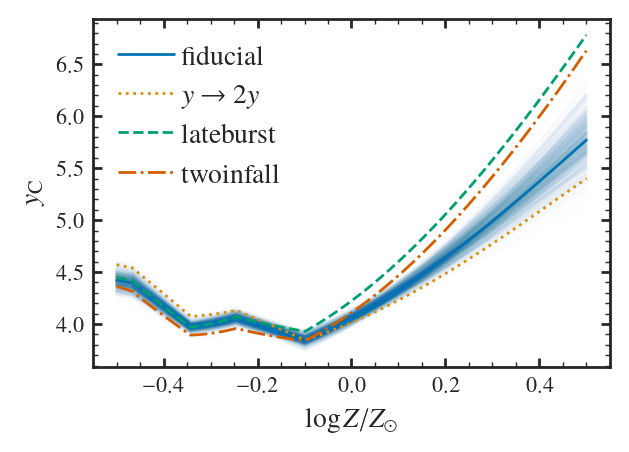

In [75]:

plt.figure()
plot_y_tot(results["fruity"], y_agbs["fruity"], thin=100, alpha=0.01, color=arya.COLORS[0])

for i, (key, label) in enumerate(plot_labels.items()): 
    result = results[key]
    if key in y_agbs.keys():
        y_agb = y_agbs[key]
    else:
        print("warning, no agb for ", key)
        
        y_agb = y_agbs["fruity"]

    
    plot_y_tot_mean(result, y_agb, color=arya.COLORS[i], label=label, ls=["-", ":", "--", "-."][i%4])
    

plt.xlabel(r"$\log Z / Z_\odot$")
plt.ylabel(r"$y_{\rm C}$")

plt.legend()


In [ ]:
Nr = len(plot_labels)
fig, axs = plt.subplots(Nr, 1, figsize=(3, 6), sharex="col", sharey=True, gridspec_kw={"hspace": 0})

for i, (key, label) in enumerate(plot_labels.items()): 
    result = results[key]
    plt.sca(axs[i])
    if key in y_agbs.keys():
        y_agb = y_agbs[key]
    else:
        print("warning, no agb for ", key)
        
        y_agb = y_agbs["fruity"]
        
    plot_y_tot(result, y_agb, thin=100, alpha=0.01)
    
    plt.ylabel(label)

fig.supylabel(r"$y_{\rm C} / y_{\rm Mg}$")

plt.xlabel(r"$\log Z / Z_\odot$")
plt.ylim(3, 8)
plt.tight_layout()


In [77]:
def compare_param_hists(results, plot_labels, var):
    Nr = len(plot_labels)
    fig, axs = plt.subplots(Nr, 1, figsize=(3, 2), sharex="col", gridspec_kw={"hspace": 0})
    
    for i, (key, label) in enumerate(plot_labels.items()):
        if key == "hline":
            ax = axs[i]
            plt.sca(axs[i])
            ax.spines[['bottom', 'top']].set_visible(False)
            plt.axhline(0.5, color=label, linestyle=":")
            ax.xaxis.set_visible(False)
            ax.set_yticks([])
            ax.set_yticks([], minor=True)
            
            continue
    
        color = arya.COLORS[i]
        
        result = results[key]
        ax = axs[i]
        plt.sca(axs[i])
        ls = "-"
        plt.hist(result.samples[var], histtype="step", color=color, ls=ls)
        plt.ylabel(label, rotation=0, ha="right", va="center")
        
        if Nr - 1 > i > 0:
            ax.spines[['bottom', 'top']].set_visible(False)
            ax.xaxis.set_visible(False)
        elif i == 0:
            ax.spines[['bottom']].set_visible(False)
            ax.tick_params(axis='x',  bottom=False, which="both")
        elif i == Nr - 1:
            ax.spines[['top']].set_visible(False)
            ax.tick_params(axis='x',  top=False, which="both")
    
    
        ax.set_yticks([])
        ax.set_yticks([], minor=True)
    
    
    
    plt.sca(axs[-1])
    plt.xlabel(var)

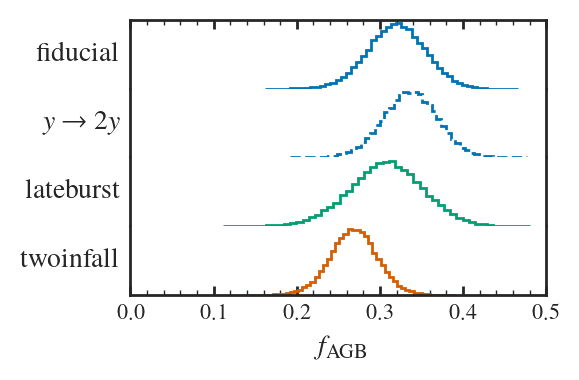

In [78]:
Nr = len(plot_labels)
fig, axs = plt.subplots(Nr, 1, figsize=(3, 2), sharex="col", gridspec_kw={"hspace": 0})

for i, (key, label) in enumerate(plot_labels.items()):
    if key == "hline":
        ax = axs[i]
        plt.sca(axs[i])
        ax.spines[['bottom', 'top']].set_visible(False)
        plt.axhline(0.5, color=label, linestyle=":")
        ax.xaxis.set_visible(False)
        ax.set_yticks([])
        ax.set_yticks([], minor=True)
        
        continue

    if i == 1:
        color = arya.COLORS[0]
        ls = "--"
    elif i < 5:
        color = arya.COLORS[i]
        ls = "-"
    elif i == 5:
        ls = "-"
        color = "k"
    else:
        ls = "--"
        color = "k"

    result = results[key]
    ax = axs[i]
    plt.sca(axs[i])
    plt.hist(result.samples.f_agb_a, histtype="step", color=color, ls=ls)
    plt.ylabel(label, rotation=0, ha="right", va="center")
    
    if Nr - 1 > i > 0:
        ax.spines[['bottom', 'top']].set_visible(False)
        ax.xaxis.set_visible(False)
    elif i == 0:
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(axis='x',  bottom=False, which="both")
    elif i == Nr - 1:
        ax.spines[['top']].set_visible(False)
        ax.tick_params(axis='x',  top=False, which="both")


    ax.set_yticks([])
    ax.set_yticks([], minor=True)



plt.sca(axs[-1])
plt.xlabel(r"$f_{\rm AGB}$")
plt.xlim(0, 0.5)

plt.tight_layout()


In [79]:
def plot_all_params(plot_labels):
    for param in ["f_agb_a", "y0_cc", "zeta_cc", "A_cc", "y_tot_a", "zeta1_a"]:
        compare_param_hists(results, plot_labels,  param)
        plt.show()

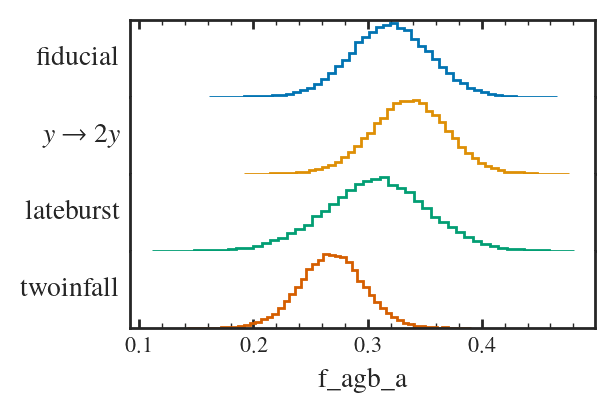

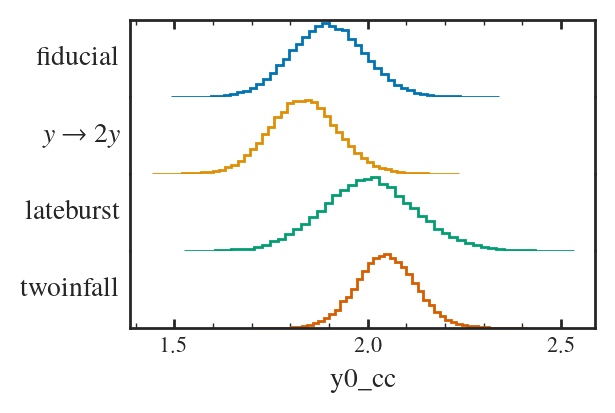

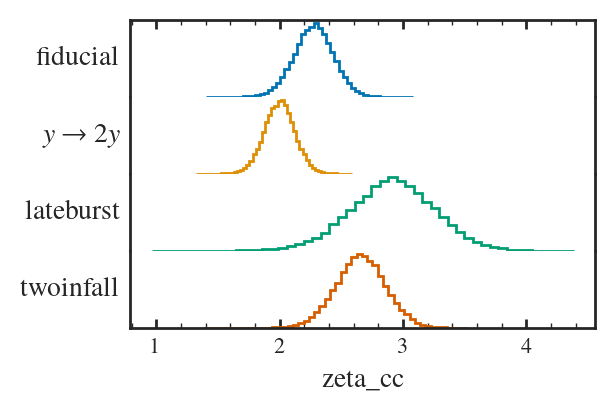

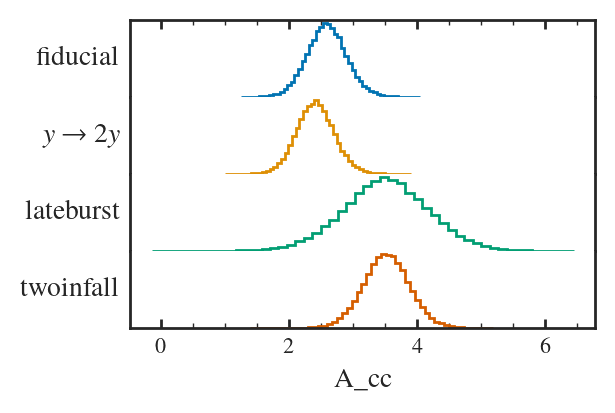

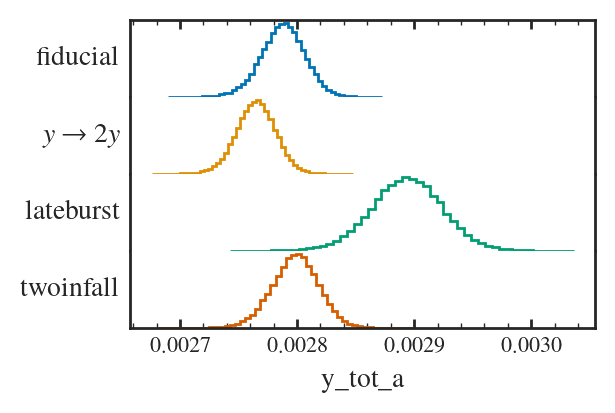

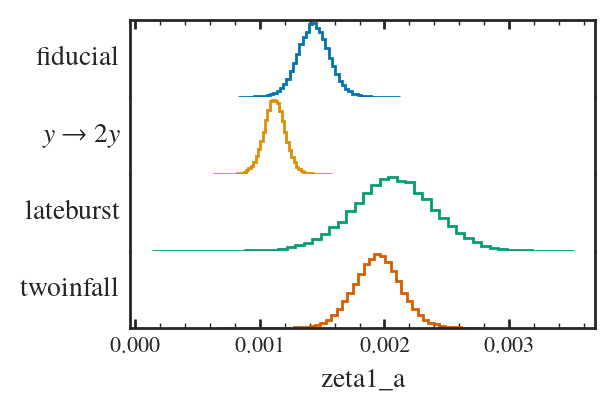

In [80]:
plot_all_params(plot_labels)

In [208]:
plot_labels = {
    "fruity": r"FRUITY",
    "aton": r"ATON",
    "monash": r"Monash",
    "nugrid": r"NuGrid",
    "fruity_m0.7": r"FRUITY m0.7",

    "eta2": r"$y\rightarrow 2y$",
    "lateburst": r"lateburst",
    "twoinfall": r"twoinfall",
    "snia_1.2": r"SNIa 1.2x",
}

f =  0.13261648745519716  key,  fruity
f =  0.03584229390681004  key,  aton
f =  0.08243727598566308  key,  monash
f =  0.29032258064516125  key,  nugrid
f =  0.15053763440860216  key,  fruity_m0.7
warning, eta2 not found
f =  0.13261648745519716  key,  eta2


/tmp/ipykernel_2255385/3941882599.py:39: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(f0, 0, c="black", edgecolors="black", lw=1, marker="x")
/tmp/ipykernel_2255385/3941882599.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(f0, 0, c=color, edgecolors="black", lw=0.5, marker="x")


warning, lateburst not found
f =  0.13261648745519716  key,  lateburst
warning, twoinfall not found
f =  0.13261648745519716  key,  twoinfall
warning, snia_1.2 not found
f =  0.13261648745519716  key,  snia_1.2


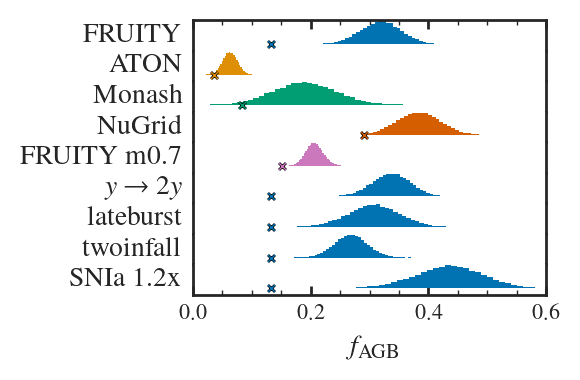

In [210]:
Nr = len(plot_labels)
fig, axs = plt.subplots(Nr, 1, figsize=(3, 2), sharex="col", gridspec_kw={"hspace": 0})

for i, (key, label) in enumerate(plot_labels.items()):
    if key == "hline":
        ax = axs[i]
        plt.sca(axs[i])
        ax.spines[['bottom', 'top']].set_visible(False)
        plt.axhline(0.5, color=label, linestyle=":")
        ax.xaxis.set_visible(False)
        ax.set_yticks([])
        ax.set_yticks([], minor=True)
        
        continue

    if i < 5:
        color = arya.COLORS[i]
        ls = "-"
    else:
        ls = "--"
        color = arya.COLORS[0]

    result = results[key]
    ax = axs[i]
    plt.sca(axs[i])
    plt.hist(result.samples.f_agb_a, color=color, ls=ls)
    plt.ylabel(label, rotation=0, ha="right", va="center")

    if key in yagb_props.keys():
        y_a = yagb_props[key]["y_a"]
    elif key == "fruity_m0.7":
        y_a = yagb_props["fruity_mf0.7"]["y_a"]
    else:
        print(f"warning, {key} not found")
        y_a = yagb_props["fruity"]["y_a"]

    f0 = y_a / 2.79e-3
    print("f = ", f0, " key, ", key)
    plt.scatter(f0, 0, c="black", edgecolors="black", lw=1, marker="x")
    plt.scatter(f0, 0, c=color, edgecolors="black", lw=0.5, marker="x")

    if Nr - 1 > i > 0:
        ax.spines[['bottom', 'top']].set_visible(False)
        ax.xaxis.set_visible(False)
    elif i == 0:
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(axis='x',  bottom=False, which="both")
    elif i == Nr - 1:
        ax.spines[['top']].set_visible(False)
        ax.tick_params(axis='x',  top=False, which="both")


    ax.set_yticks([])
    ax.set_yticks([], minor=True)
    plt.ylim(-1000)



plt.sca(axs[-1])
plt.xlabel(r"$f_{\rm AGB}$")
plt.xlim(0, 0.6)

plt.tight_layout()
plt.savefig("figures/mcmc_fagb.pdf")

In [103]:
plot_labels = {
    "fruity": r"FRUITY",
    "aton": r"ATON",
    "monash": r"Monash",
    "nugrid": r"NuGrid",
    "fruity_m0.7": "FRUITY m0.7",
}

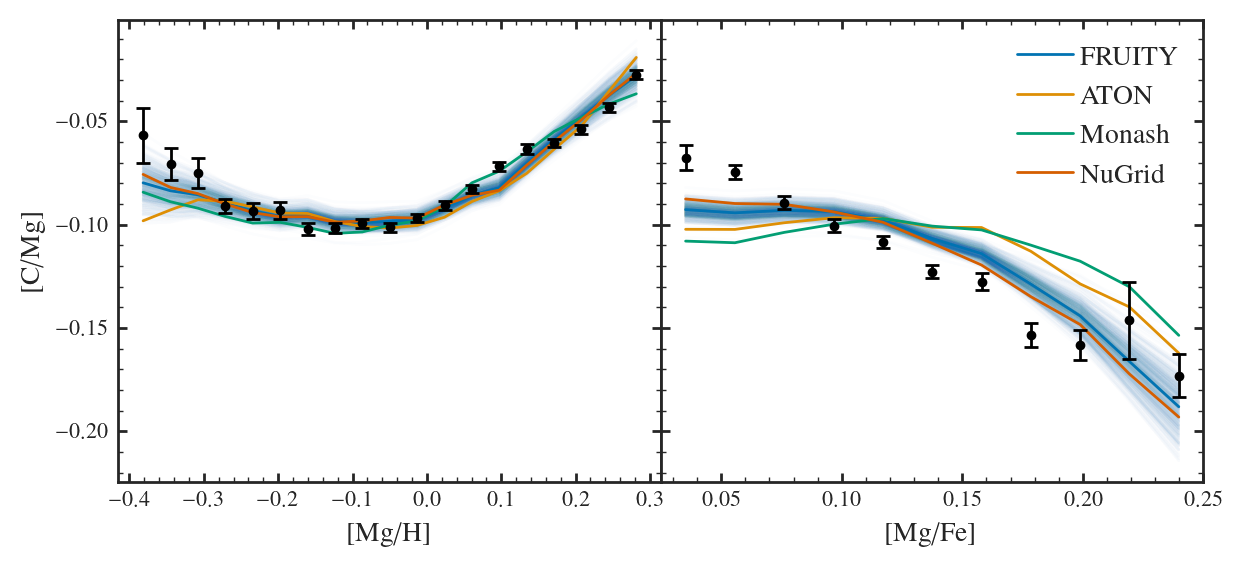

In [112]:

fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex="col", sharey=True,  gridspec_kw={"wspace": 0, "hspace": 0})

plt.sca(axs[0])
mc_plot_utils.plot_samples_caah(results["fruity"], color=arya.COLORS[0], alpha=0.01, skip=100)
for i, (key, label) in enumerate(plot_labels.items()):
    mc_plot_utils.plot_samples_caah_mean(results[key], label=label, color=arya.COLORS[i])


mc_plot_utils.plot_obs_caah(results["analytic"], color="black")


plt.sca(axs[1])
mc_plot_utils.plot_samples_caafe(results["fruity"], color=arya.COLORS[0], alpha=0.01, skip=100)

for key, label in plot_labels.items():
    mc_plot_utils.plot_samples_caafe_mean(results[key], label=label)
mc_plot_utils.plot_obs_caafe(results["analytic"], color="k")
plt.ylabel("")
plt.legend()


In [105]:
import mw_model_plots

Text(0, 0.5, '')

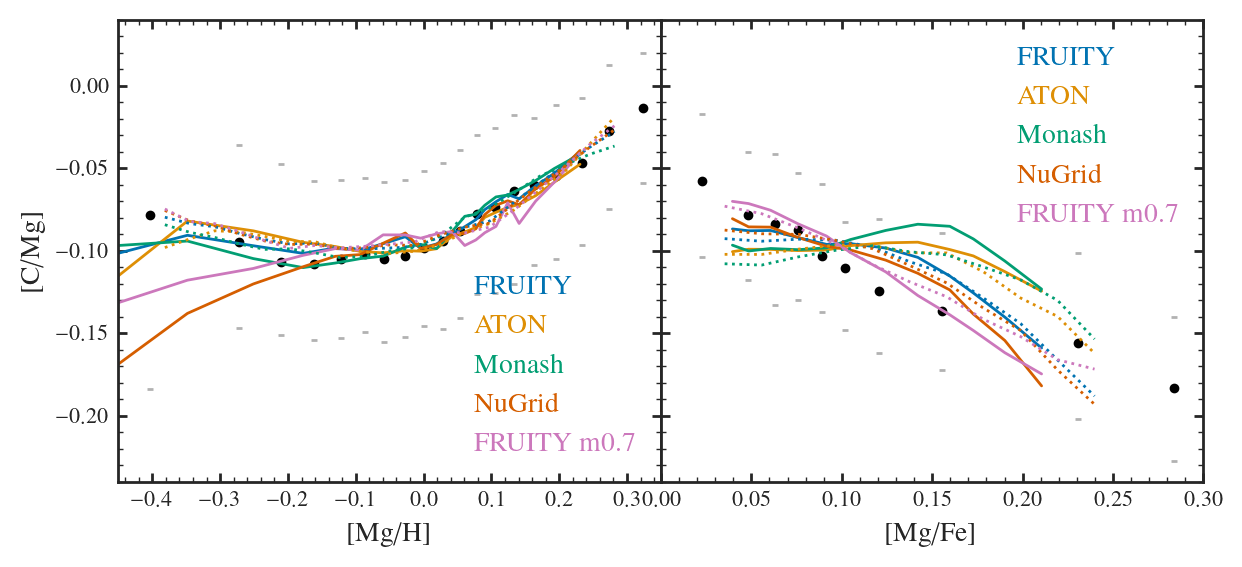

In [120]:
plot_labels = {
    "fruity": r"FRUITY",
    "aton": r"ATON",
    "monash": r"Monash",
    "nugrid": r"NuGrid",
    "fruity_m0.7": "FRUITY m0.7"
}

names = [    
    "fiducial/run",
    "aton/best",
    "monash/best",
    "nugrid/best",
    "fruity/agb_mass_0.7_alpha/",

  # "analytic/mc_best",
  ]

labels = ["FRUITY", "ATON", "Monash",  "NuGrid", "FRUITY m0.7"]




fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex="col", sharey=True,  gridspec_kw={"wspace": 0, "hspace": 0})

plt.sca(axs[0])

mw_model_plots.compare_cooh(names, labels)

for i, (key, label) in enumerate(plot_labels.items()):
    mc_plot_utils.plot_samples_caah_mean(results[key], color=arya.COLORS[i], linestyle=":")



plt.sca(axs[1])
mw_model_plots.compare_coofe(names, labels)
for key, label in plot_labels.items():
    mc_plot_utils.plot_samples_caafe_mean(results[key],linestyle=":")


plt.ylabel("")


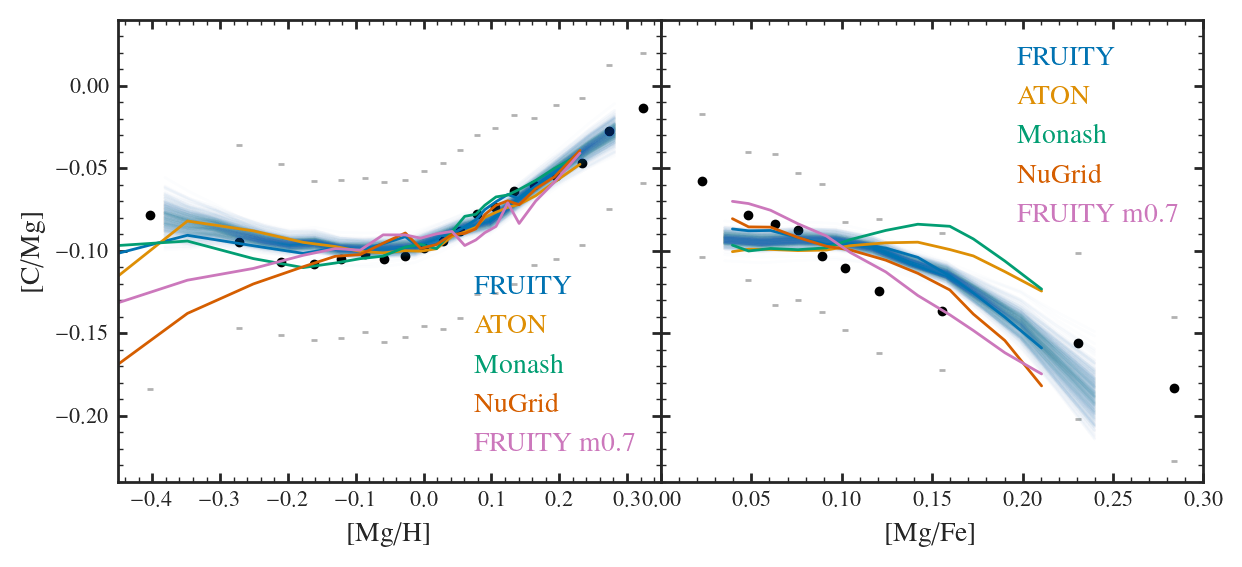

In [117]:
names = [    
    "fiducial/run",
    "aton/best",
    "monash/best",
    "nugrid/best",
    "fruity/agb_mass_0.7_alpha/",
  # "analytic/mc_best",
  ]

labels = ["FRUITY", "ATON", "Monash",  "NuGrid", "FRUITY m0.7"]




fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex="col", sharey=True,  gridspec_kw={"wspace": 0, "hspace": 0})

plt.sca(axs[0])
mc_plot_utils.plot_samples_caah(results["fruity"], color=arya.COLORS[0], alpha=0.01, skip=100)
mw_model_plots.compare_cooh(names, labels)


plt.sca(axs[1])
mc_plot_utils.plot_samples_caafe(results["fruity"], color=arya.COLORS[0], alpha=0.01, skip=100)
mw_model_plots.compare_coofe(names, labels)

plt.ylabel("")
plt.savefig("figures/mcmc_caahfe_predicted.pdf")

## Tabulated properties

In [195]:
def calc_χ2(result, median=False, normalized=False, verbose=False, generous=False):

    if median:
        samples = result.samples.median()
    else:
        samples = result.samples
        
    chi2_ah = calc_χ2_binned(result.ah, samples, result.labels, generous=generous)
    chi2_afe = calc_χ2_binned(result.afe, samples, result.labels, generous=generous)

    df = (len(result.ah) + len(result.afe)) - len(result.labels)


    if verbose:
        print("df", df)
        print("ah", chi2_ah)
        print("afe", chi2_afe)
        
    if normalized:
        return (chi2_ah + chi2_afe) / df
    else:

        return (chi2_ah + chi2_afe) 


In [196]:
def calc_χ2_binned(binned_data, samples, labels, generous = True):

    y_exp = binned_data.obs
    sigma2_exp = binned_data.obs_err**2 / (binned_data.obs_counts)

    χ2 = 0
    for i in range(len(y_exp)):
        y_tot = np.sum([binned_data[label][i] * samples[label] for label in labels], axis=0)
        sigma2_err = np.sum([binned_data[f"{label}_err"][i]**2 * samples[label] / binned_data["_counts"][i] for label in labels], axis=0)

        if generous:
            sigma_int = np.median(samples.sigma_int)
        else:
            sigma_int = 0
            
        χ2 += (y_exp[i] - y_tot)**2  / (sigma2_exp[i] + sigma2_err + sigma_int ** 2)
    
    return  χ2
    

In [197]:
calc_χ2(results["fiducial"], median=True)

np.float64(190.77562457446817)

df 26
ah 62.47384558904571
afe 128.30177898542246
fiducial 	 14.556775582843338 	 7.33752402209493

df 26
ah 82.22413789091738
afe 18.080658193533445
analytic 	 30.173196901478715 	 3.857876772478878

df 26
ah 82.84416451454169
afe 17.714965084403104
analytic_all 	 30.177262159520435 	 3.867658830728646

df 26
ah 42.3605207778299
afe 114.39495259928933
eta2 	 16.75182799365606 	 6.029056668350739

df 25
ah 330.4521192048783
afe 137.1239429533134
lateburst 	 4.460978839575881 	 18.703042486327668

df 26
ah 124.26708392803489
afe 151.56818759770806
twoinfall 	 14.20137448193303 	 10.609048904836268

df 26
ah 77.1558609682768
afe 165.23526516393392
snia_1.2 	 9.205698354286078 	 9.322735620469643

df 26
ah 79.9265455542723
afe 431.8401585887906
old_migration
old_migration 	 -7.634078330305173 	 19.68333477473319

df 26
ah 62.48785656894773
afe 129.37588770981094
fruity 	 14.551223445766544 	 7.379374779952257

df 26
ah 104.78193942022828
afe 11.873693588927068
fruity_m0.7 	 28.99777633075

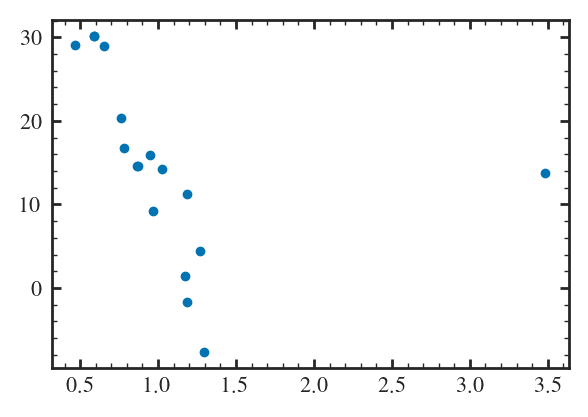

In [199]:

chi2s = []
lps = []
for label, result in results.items():
    χ2 = calc_χ2(result, median=True, normalized=True, verbose=True)
    lp = np.quantile(result.samples.lp, 0.2)
    chi2s.append(χ2)
    lps.append(lp)
    if lp < 0:
        print(label)
    print(label, "\t", lp, "\t", χ2)
    print()

plt.scatter(np.log10(chi2s), np.array(lps))


fiducial            7.34     8.41 -    0.88 +    1.54
analytic            3.86     4.31 -    0.37 +    0.64
analytic_all        3.87     4.32 -    0.37 +    0.63
eta2                6.03     6.93 -    0.71 +    1.29
lateburst          18.70    20.68 -    1.34 +    2.73
twoinfall          10.61    11.59 -    0.99 +    1.78
snia_1.2            9.32    10.64 -    1.04 +    1.93
old_migration      19.68    23.64 -    3.46 +    7.15
fruity              7.38     8.42 -    0.89 +    1.56
fruity_m0.7         4.49     5.00 -    0.47 +    0.80
fruity_lin       3035.71  3036.45 -   91.17 +   89.88
aton               14.88    17.40 -    2.53 +    4.09
monash             15.39    18.00 -    1.77 +    3.75
nugrid              5.80     6.57 -    0.63 +    1.12
analytic_eta2       2.95     3.30 -    0.32 +    0.59
analytic_lateburst   15.32    16.61 -    1.08 +    2.24
analytic_twoinfall    8.90     9.77 -    0.85 +    1.53


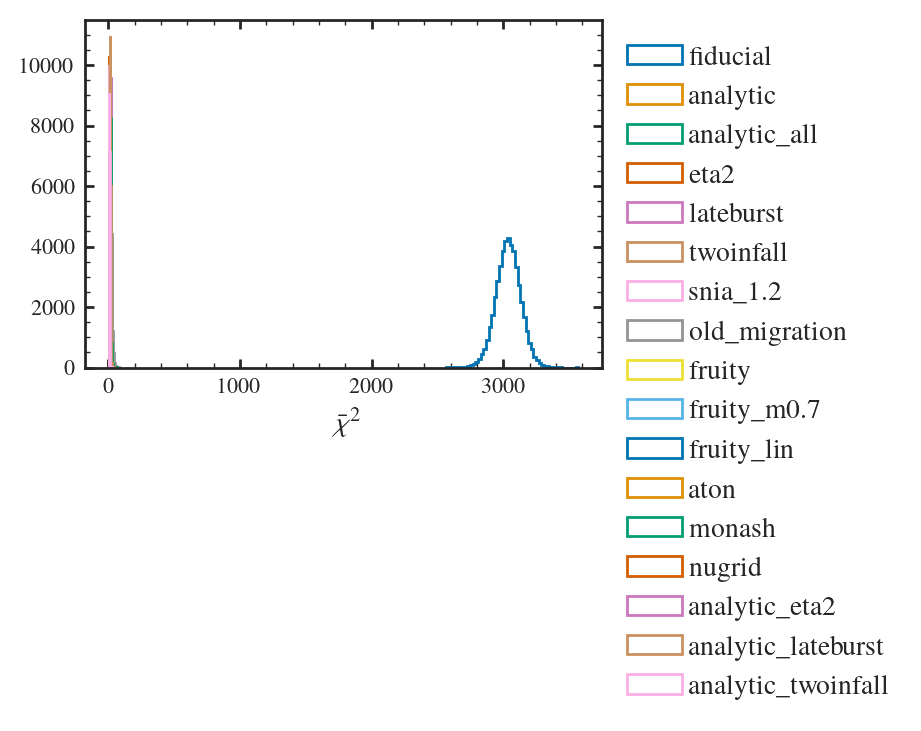

In [200]:

for label, result in results.items():
    χ2 = calc_χ2(result, median=False, normalized=True)
    lp = np.quantile(result.samples.lp, 0.95)

    m = np.median(χ2)
    l, u= np.quantile(χ2, [0.16, 0.84])

    χ2_median = calc_χ2(result, median=True, normalized=True)
    
    print(f"{label:16}{χ2_median:8.2f} {m:8.2f} -{m-l:8.2f} +{u-m:8.2f}")

    plt.hist(χ2, label=label, histtype="step")

plt.xlabel(r"$\bar\chi^2$")
arya.Legend(-1)

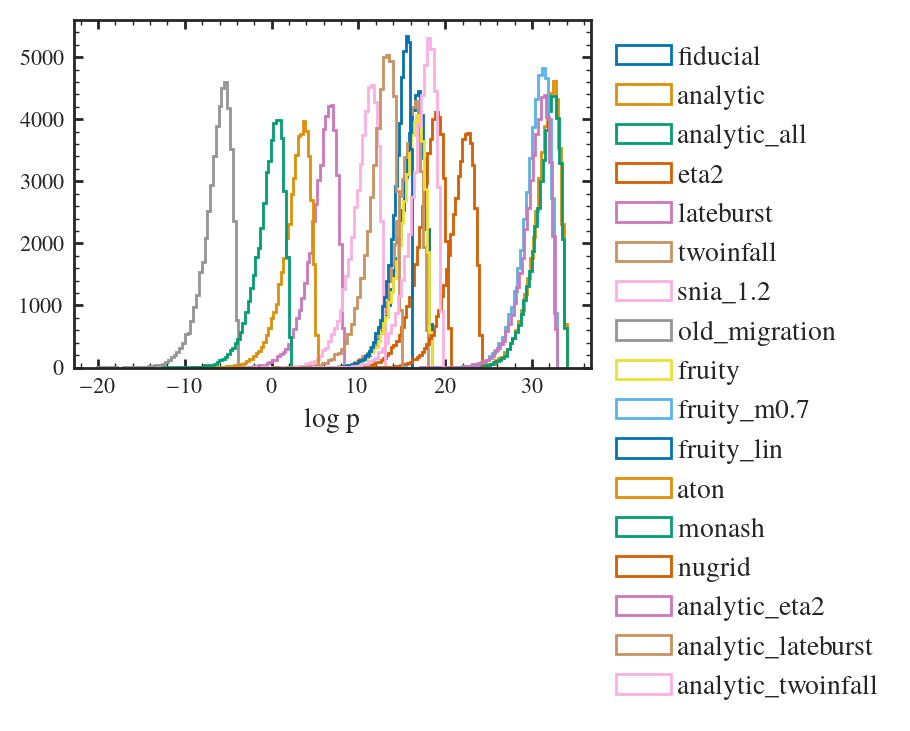

In [201]:

for label, result in results.items():
    plt.hist(result.samples.lp, label=label, histtype="step")

plt.xlabel(r"log p")
arya.Legend(-1)

In [202]:
ana = results["analytic"]

In [203]:
ana.samples.columns

Index(['iteration', 'chain', 'y0_cc', 'A_cc', 'alpha', 'zeta_cc', 'sigma_int',
       'lp', 'n_steps', 'is_accept', 'acceptance_rate', 'log_density',
       'hamiltonian_energy', 'hamiltonian_energy_error',
       'max_hamiltonian_energy_error', 'tree_depth', 'numerical_error',
       'step_size', 'nom_step_size', 'f_agb', 'y_tot', 'f_agb_a', 'y_tot_a',
       'zeta1_a'],
      dtype='object')

In [204]:
ana.samples[["zeta_cc", "zeta1_a"]].median()

zeta_cc    1.432152
zeta1_a    0.001967
dtype: float64

In [205]:
results["fruity"].samples[["zeta_cc", "zeta1_a"]].median()

zeta_cc    2.276131
zeta1_a    0.001433
dtype: float64

In [206]:
labels = {
    "fruity": r"\fruity",
    "aton": r"\aton",
    "monash": r"\monash",
    "nugrid": r"\nugrid",
    "fruity_m0.7": r"\fruity\ m0.7",
    "fruity_lin": r"\fruity\ linear",
    "eta2": r"$y\rightarrow 2y$",
    "lateburst": r"lateburst",
    "twoinfall": r"twoinfall",
    "snia_1.2": r"SN Ia 1.2",
}

In [207]:
keys = ana.labels + ["sigma_int", "f_agb_a", "y_tot_a", "zeta1_a"]
latex_table = ""

print(f"{'model':16} & $\\chi2$  & $\\log p$ & " + " & ".join(keys) + r"\\")
print("\\hline\\\\")

for key, label in labels.items():
    result = results[key]
    χ2 = calc_χ2(result, median=True, normalized=True)
    lp = np.max(result.samples.lp)

    
    # Add the row for χ2 and lp
    latex_table += f"{label:16} & {χ2:8.1f} & {lp:8.2f} & "

    # Extract parameter values and uncertainties
    parameter_lines = []
    for key in keys:
        if key not in result.samples.columns:
            parameter_lines.append(" ")
            continue
            
        if key in ["y_tot_a", "zeta1_a"]:
            x = result.samples[key] / 1e-3
        else:
            x = result.samples[key]
        median = np.median(x)
        lower, upper = np.quantile(x, [0.16, 0.84])
        uncertainty = (upper - median, median - lower)  # Asymmetric uncertainties
        formatted_value = f"${median:.2f}^{{+{uncertainty[0]:.2f}}}_{{-{uncertainty[1]:.2f}}}$"
        parameter_lines.append(f"{formatted_value}")
        
    latex_table += "  &  ".join(parameter_lines)
    latex_table += "\\\\ \n"

print(latex_table)

model            & $\chi2$  & $\log p$ & alpha & y0_cc & zeta_cc & A_cc & sigma_int & f_agb_a & y_tot_a & zeta1_a\\
\hline\\
\fruity          &      7.4 &    18.43 & $2.41^{+0.26}_{-0.27}$  &  $1.90^{+0.10}_{-0.09}$  &  $2.28^{+0.15}_{-0.16}$  &  $2.59^{+0.30}_{-0.30}$  &  $0.08^{+0.02}_{-0.01}$  &  $0.32^{+0.03}_{-0.04}$  &  $2.79^{+0.02}_{-0.02}$  &  $1.43^{+0.12}_{-0.13}$\\ 
\aton            &     14.9 &     5.30 & $1.71^{+0.34}_{-0.34}$  &  $2.55^{+0.05}_{-0.05}$  &  $3.19^{+0.40}_{-0.40}$  &  $1.92^{+0.45}_{-0.44}$  &  $0.14^{+0.03}_{-0.02}$  &  $0.06^{+0.01}_{-0.01}$  &  $2.72^{+0.03}_{-0.03}$  &  $1.48^{+0.20}_{-0.19}$\\ 
\monash          &     15.4 &     2.24 & $2.06^{+0.52}_{-0.54}$  &  $2.03^{+0.19}_{-0.18}$  &  $3.82^{+0.64}_{-0.66}$  &  $3.48^{+0.57}_{-0.59}$  &  $0.15^{+0.03}_{-0.02}$  &  $0.19^{+0.05}_{-0.05}$  &  $2.50^{+0.07}_{-0.07}$  &  $1.55^{+0.21}_{-0.22}$\\ 
\nugrid          &      5.8 &    24.19 & $1.21^{+0.11}_{-0.11}$  &  $1.58^{+0.11}_{-0.11}$  &  $1.58^{+0.11

In [99]:
# Total uncertanties
keys = ana.labels + ["sigma_int", "f_agb_a", "y_tot_a", "zeta1_a"]
latex_table = "total & & "

for key in keys:
    xs = np.array([])
    for label, result in results.items():
        if key in ["y_tot_a", "zeta1_a"]:
            x = result.samples[key] / 1e-3
        else:
            x = result.samples[key]

        xs = np.concat([x, xs])
        
    median = np.median(xs)
    lower, upper = np.quantile(xs, [0.16, 0.84])
    uncertainty = (upper - median, median - lower)  # Asymmetric uncertainties
    formatted_value = f"${median:.2f}^{{+{uncertainty[0]:.2f}}}_{{-{uncertainty[1]:.2f}}}$"
    latex_table += "  &  " + formatted_value

print(latex_table)

KeyError: 'A_cc'

In [ ]:
import weighted

In [ ]:
# weighted uncertanties
latex_table = "total & & "

for key in keys:
    xs = np.array([])
    ws = np.array([])
    for label, result in results.items():
        if key in ["y_tot_a", "zeta1_a"]:
            x = result.samples[key] / 1e-3
        else:
            x = result.samples[key]

        xs = np.concat([xs, x])
        ws = np.concat([ws, result.samples.lp])

        if key == "alpha":
            print(np.sum(result.samples.lp / np.log(10) > -2))

    ws = np.exp(ws)
    ws /= np.sum(ws)
    median = weighted.median(xs, ws)
    lower, upper = [weighted.quantile(xs, ws, q) for q in [0.16, 0.84]]
    uncertainty = (upper - median, median - lower)  # Asymmetric uncertainties
    formatted_value = f"${median:.2f}^{{+{uncertainty[0]:.2f}}}_{{-{uncertainty[1]:.2f}}}$"
    latex_table += "  &  " + formatted_value
    print(key, np.sum(xs * ws) / np.sum(ws))

print(latex_table)

In [ ]:
res = results["fiducial"].samples
plt.scatter(res.alpha, res.lp)

In [ ]:
plt.hist(np.log10(ws))

## Test comparisons

KeyError: 'galah'

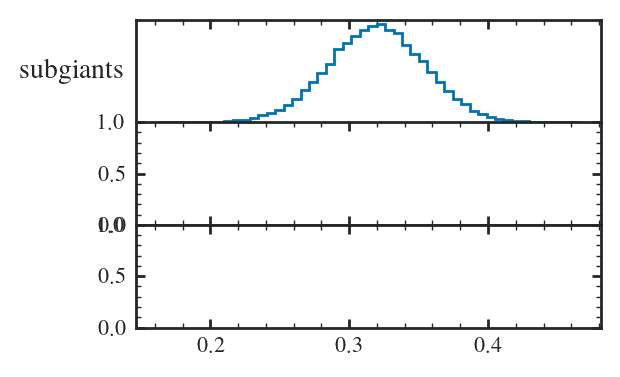

In [87]:
plot_labels = {
    "fiducial": "subgiants", 
    "galah": "galah",
    "v21": "v21",
    #"gso": "gso",
}
plot_all_params(plot_labels)

In [ ]:
results["galah"].afe

In [ ]:
plot_labels = {
    "fiducial": "subgiants", 
    "galah": "galah",
    "v21": "v21",
    "gso": "gso"
}


fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex="col", sharey=True,  gridspec_kw={"wspace": 0, "hspace": 0})

plt.sca(axs[0])
plot_samples_caah(results["fiducial"], color=arya.COLORS[0], alpha=0.01, skip=30)
for i, (key, label) in enumerate(plot_labels.items()):
    plot_samples_caah_mean(results[key], label=label, color=arya.COLORS[i])




plt.sca(axs[1])
plot_samples_caafe(results["fiducial"], color=arya.COLORS[0], alpha=0.01, skip=30)

for key, label in plot_labels.items():
    plot_samples_caafe_mean(results[key], label=label)
#plot_obs_caafe(results["analytic"], color="k")
plt.ylabel("")
plt.legend()


In [ ]:
Nr = len(plot_labels)
fig, axs = plt.subplots(Nr, 2, figsize=(6, 9), sharex="col", sharey=True, gridspec_kw={"hspace": 0, "wspace": 0})

for i, (key, label) in enumerate(plot_labels.items()):
    ax = axs[i]
    plt.sca(axs[i][0])
    
    if key == "hline":
        continue

    result = results[key]
    
    plot_samples_caah(result)
    plt.ylabel(label, rotation=0, ha="right", va="center")


    plt.sca(axs[i][1])
    plot_samples_caafe(result)
    plt.ylabel("")

    

plt.yticks([-0.05, -0.10, -0.15, -0.20])
plt.ylim(-0.2, 0)

fig.supylabel("[C/Mg]")
plt.tight_layout()


In [ ]:
results["analytic"].labels

In [ ]:
def plot_all_params(plot_labels):
    for param in ["alpha", "zeta0", "zeta1", "zeta2"]:
        compare_param_hists(test_results, plot_labels,  param)
        plt.show()

In [ ]:
plot_labels = {
    "NUTS": "NUTS", 
    "HMC": "HMC",
    "RWMH": "RWMH",
    "add_rand_scatter": "syn scatter",
}

In [ ]:
plot_all_params(plot_labels)

In [ ]:
plot_labels = {
    "NUTS": "fiducial", 
    "fine_bins": "fine_bins",
    "superfine_bins": "superfine_bins",
    "equal_num_bins": "equal number",
    "equalnum_fine": "equal number fine",
}

In [ ]:
plot_all_params(plot_labels)

In [ ]:
plot_labels = {
    "NUTS": "fiducial", 
    "t_test": "t test",
    "2s": "both uncertanties",
}

In [ ]:
plot_all_params(plot_labels)

# Validation

In [ ]:
result = MCMCResult.from_file("analytic_quad")

In [ ]:
np.median(result.samples, axis=0)

In [ ]:

df = mz_stars[~mz_stars.high_alpha]

mg_h_bins = np.arange(-0.5, 0.31, 0.1)

bin_mids = (mg_h_bins[1:] + mg_h_bins[:-1])/2
ss = binned_statistic(df.MG_H, df.C_MG, bins=mg_h_bins, statistic="mean").statistic
se = binned_statistic(df.MG_H, df.C_MG, bins=mg_h_bins, statistic="std").statistic

In [ ]:
plot_samples_caah(result)

plt.errorbar(bin_mids, ss, yerr=se, fmt="o")

In [ ]:

df = mz_stars[(mz_stars.MG_H > -0.15 ) & (mz_stars.MG_H < -0.05)]

mg_h_bins = np.arange(0, 0.31, 0.05)

bin_mids = (mg_h_bins[1:] + mg_h_bins[:-1])/2
ss = binned_statistic(df.MG_FE, df.C_MG, bins=mg_h_bins, statistic="mean").statistic
se = binned_statistic(df.MG_FE, df.C_MG, bins=mg_h_bins, statistic="std").statistic

In [ ]:
plot_samples_caafe(result)

plt.errorbar(bin_mids, ss, yerr=se, fmt="o")